# Predict Average Bunker Score

Preidcts the average score for each bunker solely based on the sentiment analysis of the text in each review.

### 1. Imports

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### 2: File paths

In [19]:
data_path = "../../data/processed/processed_bunker_sentiment.pkl"
model_path = "../outputs_final/bunker_multi_class/final_model"

### 3: Load and filter data

In [20]:
df = pd.read_pickle(data_path)
bunker_counts = df["bunker_name"].value_counts()
valid_bunkers = bunker_counts[bunker_counts >= 100].index
df = df[df["bunker_name"].isin(valid_bunkers)].copy()
print(f"Filtered to {len(valid_bunkers)} bunkers with >= 100 reviews")

Filtered to 6 bunkers with >= 100 reviews


### 4: Load model and tokenizer

In [21]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # or "bert-base-cased"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cuda


### 5. Prediction function

In [22]:
def predict_sentiment_batch(token_batch):
    input_ids = torch.tensor([x["input_ids"] for x in token_batch]).to(device)
    attention_mask = torch.tensor([x["attention_mask"] for x in token_batch]).to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    return preds.cpu().tolist()

### 6: Predict in batches

In [23]:
batch_size = 32
tokens = df["tokens"].tolist()
predictions = []

for i in tqdm(range(0, len(tokens), batch_size)):
    batch = tokens[i:i+batch_size]
    preds = predict_sentiment_batch(batch)
    predictions.extend(preds)

100%|██████████| 435/435 [02:01<00:00,  3.57it/s]


### 7. Add predictions to dataframe

In [24]:
df["predicted_label"] = predictions
label_to_score = {0: -1, 1: 0, 2: 1}
df["sentiment_score"] = df["predicted_label"].map(label_to_score)

### 8. Aggregate scores per bunker

In [25]:
bunker_scores = df.groupby("bunker_name")["sentiment_score"].mean().reset_index()
bunker_scores = bunker_scores.sort_values(by="sentiment_score", ascending=False)
bunker_scores.head()

,bunker_name,sentiment_score
0,betasom,0.798627
3,larochelle_museum,0.756854
1,hamburg,0.744902
2,keromann,0.735960
5,valentine,0.728178


### 9: Save results

In [27]:
output_path = "../../data/processed/bunker_sentiment_ranking.csv"
bunker_scores.to_csv(output_path, index=False)
print(f"Saved bunker sentiment ranking to: {output_path}")

Saved bunker sentiment ranking to: ../../data/processed/bunker_sentiment_ranking.csv


### 10. Distribution of Average Sentiment Scores Across Bunkers

/tmp/ipykernel_3638887/1636872413.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sorted_scores, x="bunker_name", y="sentiment_score", palette="coolwarm")


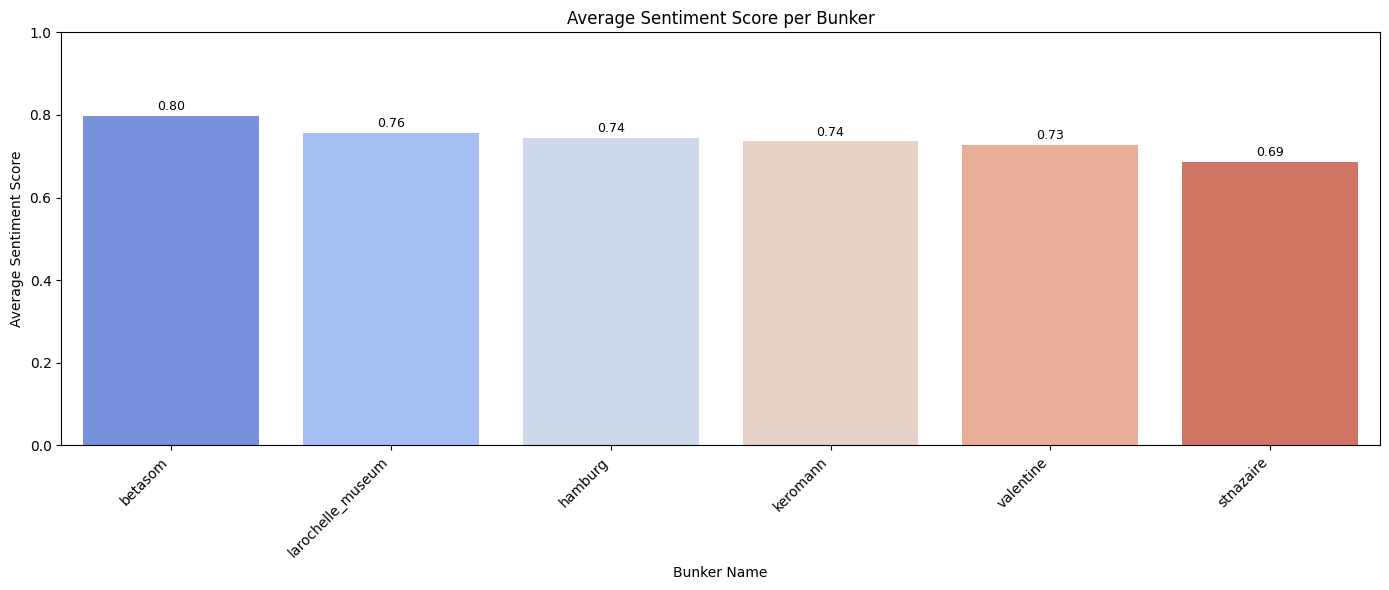

In [32]:
# Sort bunkers by sentiment score
sorted_scores = bunker_scores.sort_values(by="sentiment_score", ascending=False)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=sorted_scores, x="bunker_name", y="sentiment_score", palette="coolwarm")

plt.title("Average Sentiment Score per Bunker")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Bunker Name")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add score labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.show()


In [33]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_pickle("path/to/processed_bunker_sentiment.pkl")

# Choose one bunker and filter negative reviews
example_bunker = "Some Bunker Name"  # Replace with actual bunker name
bunker_df = df[(df["bunker_name"] == example_bunker) & (df["predicted_label"] == 0)].copy()

# Sample to reduce memory usage
sample_texts = bunker_df["clean_text"].dropna().sample(n=100, random_state=42).tolist()

# Load spaCy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Extract noun phrases
phrases = []
for doc in nlp.pipe(sample_texts, disable=["ner", "parser"]):
    phrases.extend([chunk.text.lower().strip() for chunk in doc.noun_chunks])

# Count and plot top complaint phrases
phrase_counts = Counter(phrases).most_common(15)
common_df = pd.DataFrame(phrase_counts, columns=["phrase", "count"])

plt.figure(figsize=(10, 6))
sns.barplot(data=common_df, y="phrase", x="count", palette="Reds_d")
plt.title(f"Top Complaint Phrases in Negative Reviews for '{example_bunker}'")
plt.xlabel("Frequency")
plt.ylabel("Phrase")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'spacy'